In [1]:
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym
from source.algorithms import *
import source.config as config
import source.farm_env # Import necessary to register the gym environment

[-0.999, -0.989, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, -0.72, 0.05]
[-0.053926197030622854, -0.06507058538713577, 0.003981957393304688, 0.005743810500452767, 0.007999322523201284, 0.01083766031924826, 0.014353655021550926, 0.018645692061831913, 0.023812981332620217, 0.029952217270546082, 0.0371536764494309, 0.04549684227244139, 0.055045690251302355, 0.06584381029144142, 0.07790958108225665, 0.09123164263929748, 0.10576493284975949, 0.12142755950202881, 0.13809876839474122, 0.15561823936806574, 0.17378689535282463, 0.19236934604607994, 0.21109801027633507, 0.22967887354554029, 0.24779874479244035, -0.6817725902030741, 0.048510171895712904]


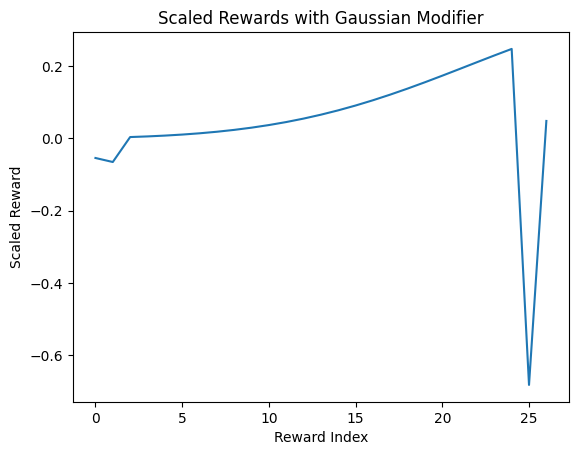

In [21]:
import numpy as np
import math
import matplotlib.pyplot as plt

rewards = [-0.999, -0.989, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, -0.72, 0.05]

print(rewards)

gaussian_rewards = []
sigma = 12

for i, reward in enumerate(rewards):
    reward = np.clip(reward, -0.999, 0.999)
    std_reward = (reward - (-0.999)) / (0.999 - (-0.999))
    scaled_reward = std_reward * (1 - -1) + -1
    gaussian_modifier = math.exp(-((i+1) - 30)**2 / (2 * (sigma**2)))
    gaussian_rewards.append(scaled_reward * gaussian_modifier)

print(gaussian_rewards)
# plt.plot(range(len(gaussian_rewards[2:-2])), gaussian_rewards[2:-2])
plt.plot(range(len(gaussian_rewards)), gaussian_rewards)
plt.xlabel('Reward Index')
plt.ylabel('Scaled Reward')
plt.title('Scaled Rewards with Gaussian Modifier')
plt.show()

Correlation final sheep_count/budget

In [1]:
import source.config as config
from source.algorithms import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import source.farm_env # Import necessary to register the gym environment

In [2]:
env = gym.make(id='FarmEnv-v0',
                initial_budget = config.INITIAL_BUDGET,
                sheep_cost = config.SHEEP_COST,
                wheat_cost = config.WHEAT_COST,
                wool_price = config.WOOL_PRICE,
                wheat_price = config.WHEAT_PRICE,
                max_years = config.MAX_YEARS,
                wool_fixed_cost = config.WOOL_FIXED_COST,
                storm_probability = config.STORM_PROBABILITY,
                incest_penalty = config.INCEST_PENALTY,
                reward_std = config.SIGMA
                )

In [27]:
learning_rate = 0.001
policy_learning_rate = 1e-4
value_learning_rate = 1e-4
n_episodes = 300_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes)  # reduce the exploration over time
final_epsilon = 0.1

REINFORCE_agent = FarmAgentNeuralREINFORCEAdvantage(
    environment=env, policy_learning_rate=policy_learning_rate, value_learning_rate=value_learning_rate, epsilon=start_epsilon, epsilon_decay=epsilon_decay, final_epsilon=final_epsilon, gamma=.999,
    policy_net_weights_path=r'agent_models\REINFORCENeuralAdvantage\sigma8-incestpenalty2.5-epsilondecay1-gamma0.999-800k\policy_net_weights.pth',
    value_net_weights_path=r'agent_models\REINFORCENeuralAdvantage\sigma8-incestpenalty2.5-epsilondecay1-gamma0.999-800k\value_net_weights.pth'
)

In [28]:
def generate_trajectories(env, REINFORCE_agent, num_trajectories=10000, trajectory_length=30):
    final_sheep_counts = []
    final_budgets = []

    for _ in tqdm(range(num_trajectories)):
        state, info = env.reset()
        for _ in range(trajectory_length):
            action = REINFORCE_agent.policy(state, greedy=True)
            s_prime, reward, terminated, truncated, info = env.step(action)
            
            if terminated or truncated:
                break
            else:
                state = s_prime

        final_sheep_counts.append(state['sheep_count'])
        final_budgets.append(state['budget'])

    return final_sheep_counts, final_budgets

In [29]:
# Generate trajectories
final_sheep_counts, final_budgets = generate_trajectories(env, REINFORCE_agent)

100%|██████████| 10000/10000 [00:45<00:00, 220.40it/s]


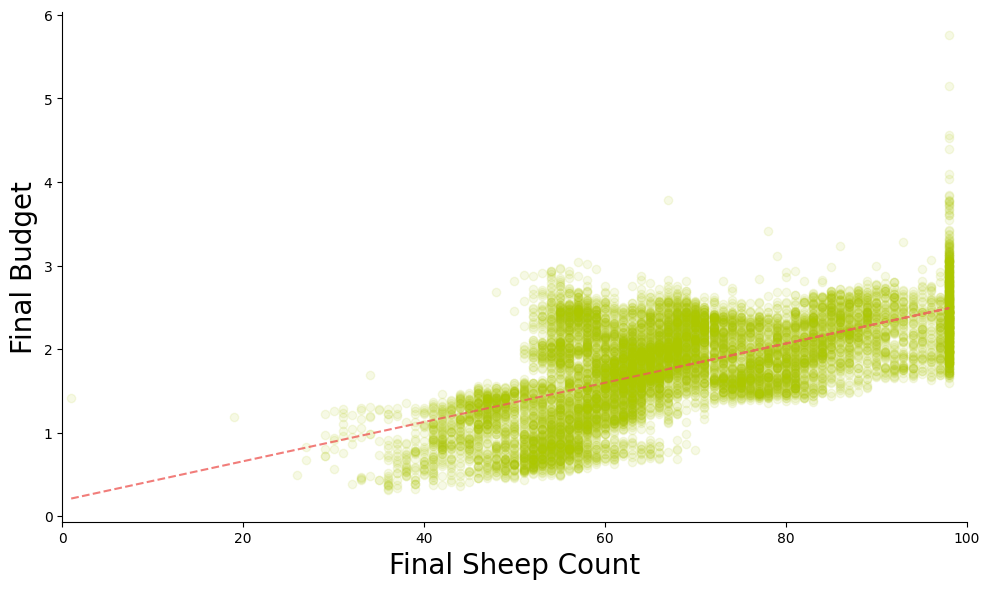

Average final sheep count: 68.39
Average final budget: 1.79
Correlation coefficient: 0.63


In [49]:
# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(final_sheep_counts, final_budgets, alpha=0.1, color='#acc700')
plt.xlabel('Final Sheep Count', size=20)
plt.ylabel('Final Budget', size=20)
# plt.title('Correlation between Final Sheep Count and Final Budget')


# Add trend line
z = np.polyfit(final_sheep_counts, final_budgets, 1)
p = np.poly1d(z)
plt.plot(final_sheep_counts, p(final_sheep_counts), "--", alpha=0.8, color='#ee5c59')
plt.xlim(0, 100)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

################################################
# CORRELATION

# Calculate and display correlation coefficient
correlation = np.corrcoef(final_sheep_counts, final_budgets)[0, 1]
# plt.text(0.05, 0.85, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, size=30)
# Print summary statistics
print(f"Average final sheep count: {np.mean(final_sheep_counts):.2f}")
print(f"Average final budget: {np.mean(final_budgets):.2f}")
print(f"Correlation coefficient: {correlation:.2f}")